In [491]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def cumsum(vector):
    cumulative = []
    sum =0
    for i in vector:
        if i == None:
            cumulative.append(None)
        else:
            sum += i
            cumulative.append(sum)
    return cumulative

def fgsm_attack(target, epsilon, x, y, n_classes):
    
    if n_classes <=2:
        label = y.copy()
        dlt =  [target.predict_proba(x)[0][0] - label]
    else:
        label = np.zeros(n_classes)
        label[y] = 1
        dlt =  target.predict_proba(x) - label

    direction = np.sign( np.matmul( dlt, target[1].coef_ ) )
    x_attacked = x + epsilon * direction
    return x_attacked[0]



def STAP(controler_clf, controler_input, nb_mistakes, i):    

    initial_action = controler_clf.predict(controler_input)[0]
    r = np.random.uniform(0,1)
    flip_proba = np.sqrt( (1+nb_mistakes)/(i+1) )
    if (initial_action == 1 or initial_action == 0) and r <= flip_proba:
        STAP_action = 1
    else:
        STAP_action = 0
    
    return initial_action, STAP_action

def CesaBianchi(controler_clf, controler_input, beta, K):

    controler_pred = controler_clf.decision_function(controler_input)[0]
    initial_action = controler_clf.predict(controler_input)[0] 
    p = beta / ( beta + abs( controler_pred ) )
    cesa_action = np.random.binomial(1, p)
    
    return initial_action, cesa_action
    

def PLOT(epsilon,):
    q = np.random.binomial(1, epsilon)


def generate_sequence(self,k, X_test, y_test, attack_label,n_classes,epsilon):

        R = {}
        Sa = []
        for i,x,y in enumerate(zip(X_test, y_test)):
            x_attacked = fgsm_attack(self.target, epsilon, [x], y, n_classes)

            if i < t:
                v = self.target.loss_function_(x_attacked,y)
                R[i] = v
                R = {k: v for k, v in sorted(R.items(), key=lambda item: item[1])}
            else:
                v = self.target.loss_function_(x_attacked,y)
                if v>=R.values()[-1] and len(Sa)<=k:
                    del R[ R.values()[-1] ]
                    R[i] = v
                    R = {k: v for k, v in sorted(R.items(), key=lambda item: item[1])}
                    Sa.append(i)

        attack_label = [ 1 if i in Sa else 0 for i in range(len(X_test)) ]
                    
        return attack_label



In [492]:
class Task:

    def __init__(self, n, n_features, n_classes, class_sep, percent_flip, attack_proba, epsilon, seed = 42):

        X, y = make_classification(n_samples = n, n_features = n_features,  n_informative = 2, n_redundant = 1, n_classes = n_classes, flip_y = percent_flip, class_sep = class_sep, n_clusters_per_class = 1 )
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)

        self.target = make_pipeline(StandardScaler(), SGDClassifier(loss = 'log') )
        self.target.fit(X_train , y_train)

        self.X_train, self.y_train = X_train, y_train

        attack_label = generate_sequence(self,k, X_test, y_test, attack_label,n_classes,epsilon)
        #attack_label = [  np.random.choice([1,0], p=[attack_proba, 1-attack_proba]) for _ in range(len(X_test)) ]
        X_test = [ fgsm_attack(self.target, epsilon, [x], y, n_classes) if is_attacked else x for x,y, is_attacked in zip(X_test, y_test, attack_label)  ]
        X_test = np.stack( X_test, axis=0 )
        self.X_test, self.y_test = X_test, y_test
        self.attack_label = attack_label
    

    def init_controler(self,n_classes):
        controler_clf = SGDClassifier(loss = 'hinge')
        y_class = np.zeros(n_classes)
        y_class[self.y_train[0]]=1
        x_init = np.concatenate([self.X_train[0], y_class])
        controler_clf.partial_fit( [x_init], [0], [1,0]  ) 
        return controler_clf

    def online(self, method, beta=1 ):

        controler_clf = self.init_controler()
        regrets = []
        K, attacks,i, abs_false_pos, abs_true_pos, false_pos, true_pos,  = 0,0,0,0,0,0,0
        for x, y_true, is_attacked in zip(self.X_test, self.y_test, self.attack_label):

            target_pred = self.target.predict_proba([x]) 
            controler_input = np.reshape( np.concatenate(( x, target_pred[0])), (1,-1) )

            if method == 'STAP':
                initial_action, decision = STAP(controler_clf, controler_input, K, i) 
            elif method == 'Cesa':
                initial_action, decision = CesaBianchi(controler_clf, controler_input, beta, K)

            if decision == 1:
                if is_attacked != initial_action:
                    controler_clf.partial_fit(controler_input, [is_attacked], [1,0])  
                    K = K+1  

            abs_true_pos = abs_true_pos+1 if decision == 1 and is_attacked == 1 else abs_true_pos
            abs_false_pos = abs_false_pos+1 if decision == 1 and is_attacked == 0 else abs_false_pos
            true_pos = true_pos+1 if initial_action == 1 and is_attacked == 1 else true_pos
            false_pos = false_pos+1 if initial_action == 1 and is_attacked == 0 else false_pos
            regret = abs( decision - is_attacked)
            regrets.append(regret)
            attacks = attacks+1 if is_attacked == 1 else attacks
            i+=1

        plt.plot( cumsum(regrets) )
        plt.xlabel('Iteration')
        plt.ylabel('Cumulative Regret')
        print('     True positive:{},      False positive:{}'.format(true_pos,false_pos,attacks))
        print('Abs. True positive:{}, Abs. False positive:{}, Attacks:{}'.format(abs_true_pos,abs_false_pos,attacks))
                
    def offline(self):

        attack_clf = SGDClassifier(loss = 'hinge')
        train_attack_label = [  np.random.choice([1,0], p=[attack_proba, 1-attack_proba]) for _ in range(len(self.X_train)) ]
        X_train_attacks = [ fgsm_attack(self.target, epsilon, [x], y, n_classes) if is_attacked else x for x,y, is_attacked in zip(self.X_train, self.y_train, train_attack_label)  ]
        X_train_attacks = np.stack( X_train_attacks, axis=0 )
    
        attack_clf.fit( X_train_attacks, train_attack_label ) 
        y_pred = attack_clf.predict( self.X_test )

        tn, fp, fn, tp = confusion_matrix( self.attack_label , y_pred).ravel()
        print('True positive:{}, False positive:{}, Attacks:{}'.format(tp,fp,sum(self.attack_label) ) )
        
    

Online STAP:
     True positive:15,      False positive:39
Abs. True positive:11, Abs. False positive:82, Attacks:52

Online Cesa Bianchi:
     True positive:16,      False positive:14
Abs. True positive:2, Abs. False positive:26, Attacks:52

Offline:
True positive:14, False positive:14, Attacks:52


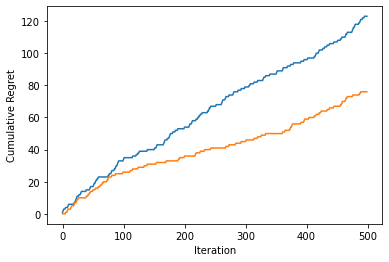

In [490]:
n = 1000
n_classes = 2
classes =  np.arange(0, n_classes)
attack_proba =  0.1
epsilon = 1
n_features = 10
class_sep = 1
percent_flip = 0.1

task = Task(n, n_features, n_classes, class_sep, percent_flip, attack_proba, epsilon)

print("Online STAP:")
task.online('STAP')
print()
print("Online Cesa Bianchi:")
task.online('Cesa',5)
print()
print("Offline:")
task.offline()